In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


/tmp/ipython-input-838591043.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_electricity.resample('1H').mean()


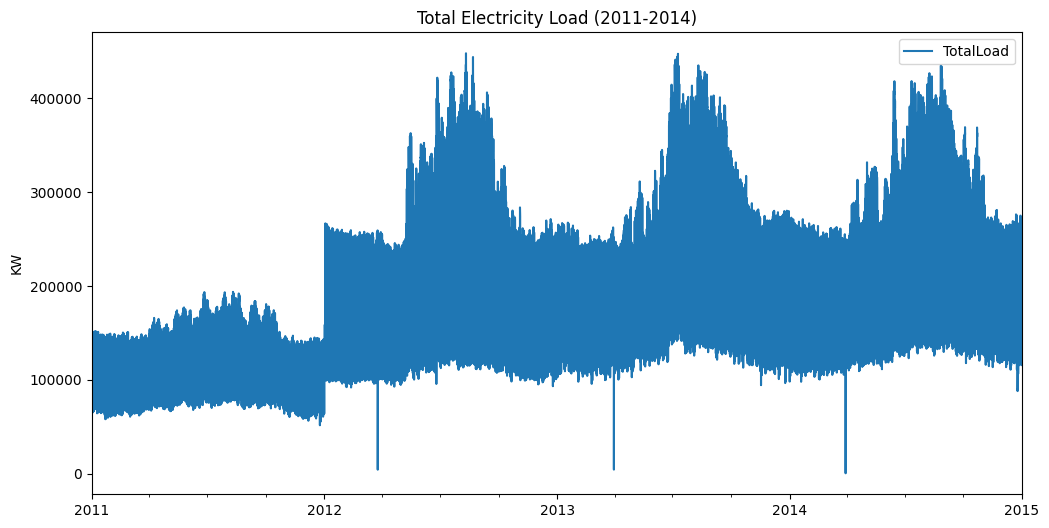

                        TotalLoad
2011-01-01 00:00:00  69019.423424
2011-01-01 01:00:00  66344.627687
2011-01-01 02:00:00  65981.054883
2011-01-01 03:00:00  66576.533566
2011-01-01 04:00:00  64963.552675


/tmp/ipython-input-838591043.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_electricity.resample('1H').mean()


New Data Shape: (35065, 1)


In [14]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# first column as index
df_electricity = pd.read_csv(
    'LD2011_2014.txt',
    sep=';',
    decimal=',',
    parse_dates=[0],
    index_col=0
)

df_hourly = df_electricity.resample('1H').mean()
df_total = df_hourly.sum(axis=1).to_frame(name='TotalLoad')

df_total.plot(y='TotalLoad', figsize=(12,6), title='Total Electricity Load (2011-2014)')
plt.ylabel('KW')
plt.show()

print(df_total.head())

#  decreasing the resolution
df_hourly = df_electricity.resample('1H').mean()
#  totalload to one column
df_total = df_hourly.sum(axis=1).to_frame(name='TotalLoad')

print(f"New Data Shape: {df_total.shape}")

In [15]:
# 1. Data Preparation with Validation Split
test_hours = 24 * 30       # 30 days for testing
val_hours = 24 * 14        # 14 days for validation

# Split the data
train_df = df_total.iloc[:-(test_hours + val_hours)]
val_df = df_total.iloc[-(test_hours + val_hours):-test_hours]
test_df = df_total.iloc[-test_hours:]

print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}")

# Scaling (Fit only on Train!)
scaler = MinMaxScaler(feature_range=(0, 1))
train_np = scaler.fit_transform(train_df).flatten()
val_np = scaler.transform(val_df).flatten()
test_np = scaler.transform(test_df).flatten()

def create_sequences(data, window=24):
    xs, ys = [], []
    for i in range(len(data) - window):
        xs.append(data[i:i+window])
        ys.append(data[i+window])
    return np.array(xs), np.array(ys)

WINDOW_SIZE = 24
X_train, y_train = create_sequences(train_np, WINDOW_SIZE)
X_val, y_val = create_sequences(val_np, WINDOW_SIZE)
X_test, y_test = create_sequences(test_np, WINDOW_SIZE)

# to Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

# DataLoader to save memory
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=64)

Train shape: (34009, 1), Val shape: (336, 1), Test shape: (720, 1)


In [16]:
# the model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        # changed to LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)

        # takes the last time step output
        out = out[:, -1, :]
        return self.fc(out)

model = LSTMRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 5/50 | Train Loss: 0.000538 | Val Loss: 0.000224
Epoch 10/50 | Train Loss: 0.000397 | Val Loss: 0.000908
Epoch 15/50 | Train Loss: 0.000330 | Val Loss: 0.000215
Epoch 20/50 | Train Loss: 0.000296 | Val Loss: 0.000173
Epoch 25/50 | Train Loss: 0.000303 | Val Loss: 0.000147
Epoch 30/50 | Train Loss: 0.000268 | Val Loss: 0.000114
Epoch 35/50 | Train Loss: 0.000255 | Val Loss: 0.000204
Epoch 40/50 | Train Loss: 0.000221 | Val Loss: 0.000106
Epoch 45/50 | Train Loss: 0.000214 | Val Loss: 0.000653
Epoch 50/50 | Train Loss: 0.000208 | Val Loss: 0.000089


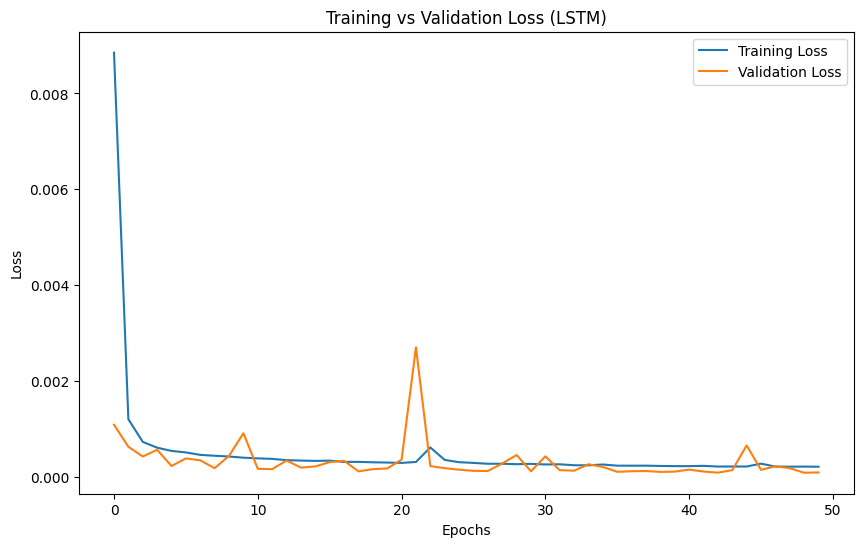

In [17]:
# train
train_loss_history = []
val_loss_history = []
epochs = 50

for epoch in range(epochs):
    # training phase
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_y_val)
            epoch_val_loss += loss_val.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Training vs Validation Loss (LSTM)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Test RMSE: 6341.57 KW


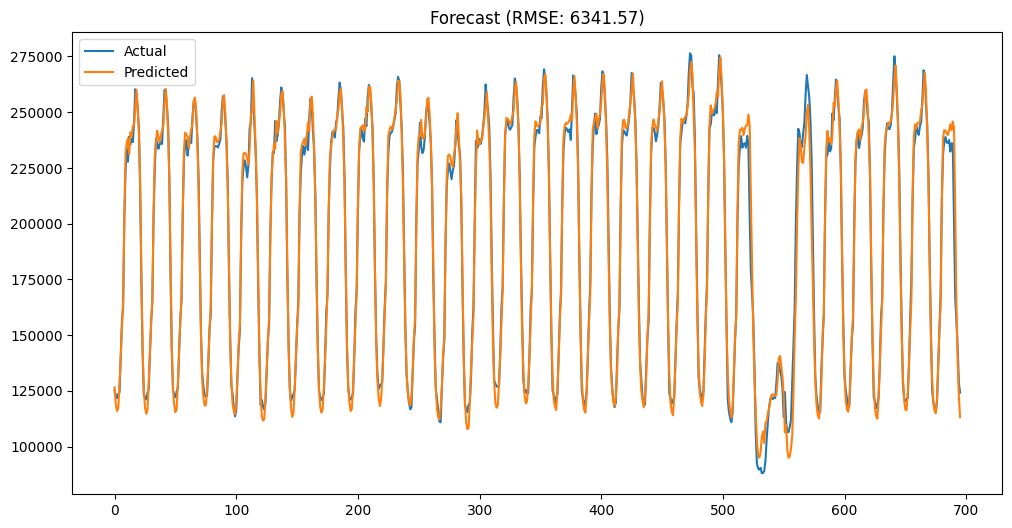

In [18]:
# evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_t).cpu().numpy()
    actual = y_test_t.cpu().numpy()

# inverse Transform
preds_inv = scaler.inverse_transform(preds)
actual_inv = scaler.inverse_transform(actual)

# RMSE
rmse = np.sqrt(np.mean((preds_inv - actual_inv)**2))
print(f"Test RMSE: {rmse:.2f} KW")

plt.figure(figsize=(12,6))
plt.plot(actual_inv, label='Actual')
plt.plot(preds_inv, label='Predicted')
plt.legend()
plt.title(f"Forecast (RMSE: {rmse:.2f})")
plt.show()